# Example patients
---
A notebook that plots creatinine trajectories for example patients for each of the featured definitions: RMW, HBT, and BCI acute kidney injury (AKI).


In [1]:
!pip install akiFlagger


(base) c:\Users\ishan\Desktop\ishan\Projects\StandardizingAKI\notebooks>DOSKEY ls=dir 

(base) c:\Users\ishan\Desktop\ishan\Projects\StandardizingAKI\notebooks>cls


In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.dates
import matplotlib.pyplot as plt

import os
import sys

import seaborn as sns
from akiFlagger import AKIFlagger
from matplotlib_venn import venn3

from sklearn.metrics import confusion_matrix, roc_auc_score

### User-defined Functions

In [3]:
def plotCreatinineTrajectory(patient_id, rows = None, color = None, dataFRAME = None, dfMERGE = None, 
                             animate = False):
    ''' Plot the creatinine trajectory (subslice) for the selected patient
    '''
    # Params
    draws = 10 # Number of draws
    lw_diff = 1.05 # Different line widths for each draw
    alpha = 0.03 # Alpha value for glow effect
    glow_size = 5 # glow linewidth
    if color is None:
        color = colors['jasmine']
    if dataFRAME is None:
        dataFRAME = flaggerOutput
    if dfMERGE is None:
        dfMERGE = df

    plotSubset = dataFRAME.loc[dataFRAME.index.get_level_values(level='patient_id') == patient_id]
    plotSubset = plotSubset.merge(dfMERGE.creatinine, on = index) # Add in the creatinine values from df
    if rows is not None:
        plotSubset = plotSubset[rows]

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
    if animate:
        x = list()
        y = list()

        for valpair in range(plotSubset.shape[0]):
            x.append(plotSubset.index.get_level_values(level='time')[valpair])
            y.append(plotSubset.creatinine[valpair])

        for n in range(draws):
            ax.plot(x, y, color = color)
            ax.plot(x, y, color = color,
                    linewidth = glow_size+(lw_diff*n), alpha=alpha)
            plt.pause(1e-3)

    else:
        for n in range(draws):
            ax.plot(plotSubset.index.get_level_values(level='time'), plotSubset.creatinine, color = color,
                    linewidth = glow_size+(lw_diff*n), alpha=alpha)
            ax.tick_params(axis='x',which='both',bottom=False)
        ax.plot(plotSubset.index.get_level_values(level='time'), plotSubset.creatinine, color = color)
    ax.xaxis.set_major_locator(matplotlib.dates.AutoDateLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.AutoDateFormatter(matplotlib.dates.MonthLocator(), defaultfmt='%m/%Y'))
    plt.xticks(rotation=30)    #ax.set_xticklabels(plotSubset.index.get_level_values(level='time'), rotation=30)
    ax.set_xlabel('Time')
    ax.set_ylabel('Creatinine')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.set_facecolor(colors['lightgrey'])
    #return ax



def plotAKIoverlap(dataFRAME, stage = 1, returnCapturedPatients = False, plot = True):
    ''' Plotting function to illustrate the differences between which patient populations are captured by each definition
    '''
    captured_patients = dict()
    captured_patientsLIST = [set(dataFRAME[dataFRAME[col] > stage - 1].index.get_level_values(level='patient_id').unique()) for col in dataFRAME]
    captured_patients[flaggerDefinitions[0]], captured_patients[flaggerDefinitions[1]], captured_patients[flaggerDefinitions[2]] = captured_patientsLIST 

    if returnCapturedPatients & plot:
        return captured_patients, venn3(
            subsets = [captured_patients[flaggerDefinitions[0]], 
            captured_patients[flaggerDefinitions[1]], 
            captured_patients[flaggerDefinitions[2]]], set_labels = tuple(df for df in flaggerDefinitions)
        )

    if returnCapturedPatients:
        return captured_patients
    
    if plot:
        return venn3(
            subsets = [captured_patients[flaggerDefinitions[0]], 
            captured_patients[flaggerDefinitions[1]], 
            captured_patients[flaggerDefinitions[2]]], set_labels = tuple(df for df in flaggerDefinitions)
        )

### Parameters
---

#### _General parameters_

*STAGE* is the staging of AKI; 1 2 or 3. 

*index* is a Python multi-index (id est hierarchical index) 

*flaggerDefinitions* 

#### _Flagger parameters_

The definitions are specified as boolean parameters within the internal function (the main `AKIFlagger` class and the `returnAKIpatients()` function). The dictionary is essentially a mapping between the flagger definitions are string inputs to the boolean inputs; a more human-readable input into a 3D bool vector. 

`padding` defaults to 4 hours; I am *explicitly* mentioning this here to make it clear (the first small divergence from the KDIGO definitions.

In [4]:
# Parameters
STAGE = 1 
index = ["patient_id", "time"]
flaggerDefinitions = ["RMW", "HBT", "BCI"]
dataFolder = r"H:\AKIFlagger\output"
dataPath = os.path.join(dataFolder, "flaggerOutput.csv")
outcomesPath = os.path.join(dataFolder, "flaggerInput.csv") #H:\AKIFlagger\output\flagger creatinine data 04-20-2022.csv
outcomeCols = ["death_time", "dialysis_time", "progression_time"]
selectCols = ["patient_id", "time", "inpatient", "creatinine", "age", "sex", "admission", # Flagger input columns
              "admit_creatinine"] + outcomeCols # Outcome columns
vennOutPath = "vennDiagrams" # Save directories
colors = {
    '###': 'green', # Replace ### with 
    '###': 'green', # 
    '###': 'red',   # (examplePatientsRMW)
    '###': 'green', # 
    '###': 'green',  # 5 mrns in total
    'mindaro': '#dbfe87', # Mindaro
    'jasmine': '#ffe381', # Jasmine
    'lightgrey': '#6f8695', # Light Slate Grey
    'boyblue': '#80A1D4', # Little Boy Blue
    'ivory': '#f6f7eb', # Ivory
    'cinnabar': '#e94f37', # Cinnabar
    'onyx': '#393e41', # Onyx
    'lavendar': '#eae8ff', # Lavendar
}

# Flagger-specific parameters
fParams = dict() # A mapping between definition strings and booleans
fParams[flaggerDefinitions[0]] = {"RM_window": True, "HB_trumping": False, "eGFR_impute": False}
fParams[flaggerDefinitions[1]] = {"RM_window": False, "HB_trumping": True, "eGFR_impute": False}
fParams[flaggerDefinitions[2]] = {"RM_window": False, "HB_trumping": True, "eGFR_impute": True}
padding = '4hours'

### Read in the data; take a peak at what the input looks like

In [5]:
df = pd.read_csv(outcomesPath)
df = df.rename(columns={'pat_mrn_id':'patient_id'})
df['time'] = pd.to_datetime(df.time)
df = df.set_index(index)

flaggerOutput = pd.read_csv(dataPath)
flaggerOutput['time'] = pd.to_datetime(flaggerOutput.time)
flaggerOutput = flaggerOutput.set_index(index)
flaggerOutput.head()
df.head()

inpatient  creatinine      hosp_admsn_time  \
patient_id time                                                              
MR1000013  2020-09-23 23:08:00       True        0.92  2020-12-14T02:14:00   
           2020-12-11 03:04:00       True        0.98  2020-12-14T02:14:00   
           2020-12-12 10:40:00       True        0.91  2020-12-14T02:14:00   
           2020-12-13 00:42:00       True        0.99  2020-12-14T02:14:00   
           2020-12-14 03:35:00       True        0.75  2020-12-14T02:14:00   

                                    hosp_disch_time death_time       los  \
patient_id time                                                            
MR1000013  2020-09-23 23:08:00  2020-12-21T15:48:00        NaN  7.565278   
           2020-12-11 03:04:00  2020-12-21T15:48:00        NaN  7.565278   
           2020-12-12 10:40:00  2020-12-21T15:48:00        NaN  7.565278   
           2020-12-13 00:42:00  2020-12-21T15:48:00        NaN  7.565278   
           2020-12-14 03:35:00  2020-12-21T15:48:00        NaN  7.565278   

                               dialysis_time  admit_creatinine  \
patient_id time                                                  
MR1000013  2020-09-23 23:08:00           NaN              0.75   
           2020-12-11 03:04:00           NaN              0.75   
           2020-12-12 10:40:00           NaN              0.75   
           2020-12-13 00:42:00           NaN              0.75   
           2020-12-14 03:35:00           NaN              0.75   

                               progression_time  diaylsis_time        age  sex  
patient_id time                                                                 
MR1000013  2020-09-23 23:08:00              NaN            NaN  27.169863    1  
           2020-12-11 03:04:00              NaN            NaN  27.169863    1  
           2020-12-12 10:40:00              NaN            NaN  27.169863    1  
           2020-12-13 00:42:00              NaN            NaN  27.169863    1  
           2020-12-14 03:35:00              NaN            NaN  27.169863    1

### Example patients flagged as AKI

#### Basic measurement characteristics of patient data
---
`flaggerOutput.groupby('patient_id').count().RMW`  shows the number 

In [6]:
captured_patients = plotAKIoverlap(flaggerOutput, stage = 1, returnCapturedPatients=True, plot = False)
examplePatientsRMW = list(captured_patients['RMW'])[:10]
examplePatientsHBT = list(captured_patients['HBT'])[:14]
examplePatientsBCI = list(captured_patients['BCI'])[20:30]

### RMW patients

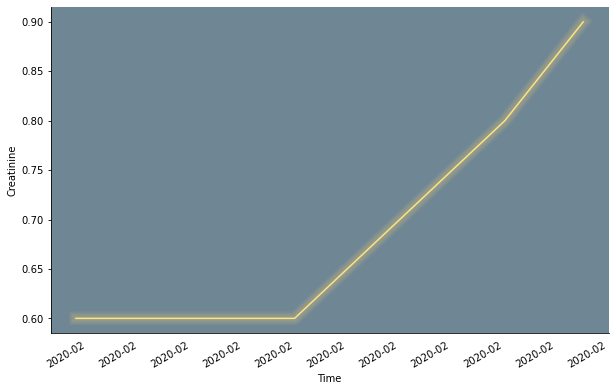

In [7]:
def plotCreatinineTrajectory(patient_id, rows = None, color = None, dataFRAME = None, dfMERGE = None, 
                             animate = False, draws = 10, lw_diff=1.05, alpha=0.03, glow_size = 5):
    ''' Plot the creatinine trajectory (subslice) for the selected patient
    '''
    # Params
    draws = 10 # Number of draws
    lw_diff = 1.05 # Different line widths for each draw
    alpha = 0.03 # Alpha value for glow effect
    glow_size = 5 # glow linewidth
    if color is None:
        color = colors['jasmine']
    if dataFRAME is None:
        dataFRAME = flaggerOutput
    if dfMERGE is None:
        dfMERGE = df

    plotSubset = dataFRAME.loc[dataFRAME.index.get_level_values(level='patient_id') == patient_id]
    plotSubset = plotSubset.merge(dfMERGE.creatinine, on = index) # Add in the creatinine values from df
    if rows is not None:
        plotSubset = plotSubset[rows]

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
    if animate:
        x = list()
        y = list()

        for valpair in range(plotSubset.shape[0]):
            x.append(plotSubset.index.get_level_values(level='time')[valpair])
            y.append(plotSubset.creatinine[valpair])

        for n in range(draws):
            ax.plot(x, y, color = color)
            ax.plot(x, y, color = color,
                    linewidth = glow_size+(lw_diff*n), alpha=alpha)
            plt.pause(1e-3)

    else:
        for n in range(draws):
            ax.plot(plotSubset.index.get_level_values(level='time'), plotSubset.creatinine, color = color,
                    linewidth = glow_size+(lw_diff*n), alpha=alpha)
            ax.tick_params(axis='x',which='both',bottom=False)
        ax.plot(plotSubset.index.get_level_values(level='time'), plotSubset.creatinine, color = color)
    ax.xaxis.set_major_locator(matplotlib.dates.AutoDateLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.AutoDateFormatter(matplotlib.dates.MonthLocator(), defaultfmt='%m/%Y'))
    plt.xticks(rotation=30)    #ax.set_xticklabels(plotSubset.index.get_level_values(level='time'), rotation=30)
    ax.set_xlabel('Time')
    ax.set_ylabel('Creatinine')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.set_facecolor(colors['lightgrey'])
ax = plotCreatinineTrajectory('MR2110315', rows = slice(0,4), animate=False)

In [8]:
flaggerOutput[flaggerOutput.index.get_level_values(level='patient_id') == 'MR282243']

RMW  HBT  BCI
patient_id time                              
MR282243   2019-11-23 17:36:00    0    0    0
           2020-02-08 22:31:00    0    1    1
           2020-02-09 06:19:00    0    1    1
           2020-02-10 06:33:00    0    1    1
           2020-02-11 07:07:00    0    0    0
           2020-02-12 07:13:00    0    0    0
           2020-02-13 05:52:00    0    1    1
           2020-02-14 06:05:00    1    1    1
           2020-02-15 06:15:00    0    1    1
           2020-02-17 05:08:00    0    0    0
           2020-02-18 06:42:00    0    0    0
           2020-02-27 03:03:00    0    0    0
           2020-05-19 20:17:00    0    2    2
           2020-05-20 06:54:00    0    2    2
           2020-05-21 07:46:00    0    1    1
           2020-05-22 08:42:00    0    1    1
           2020-05-23 05:42:00    0    1    1
           2020-05-24 07:06:00    0    1    1
           2020-05-25 07:50:00    0    1    1
           2020-05-26 06:42:00    0    1    1
           2020-05-27 08:15:00    0    0    0
           2020-05-28 07:15:00    0    0    0

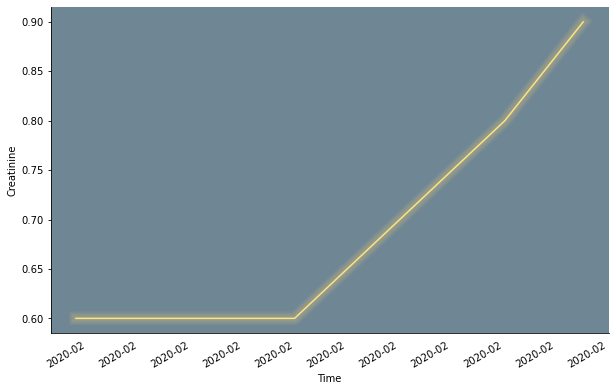

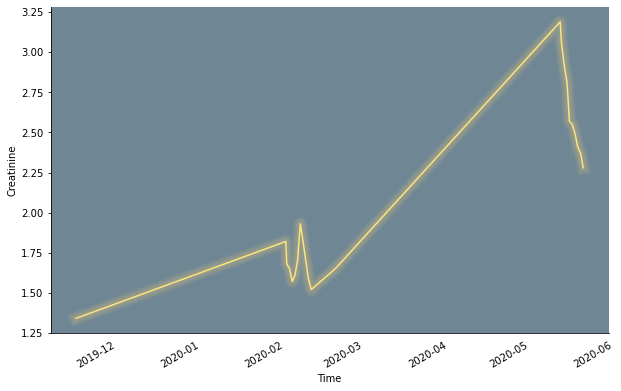

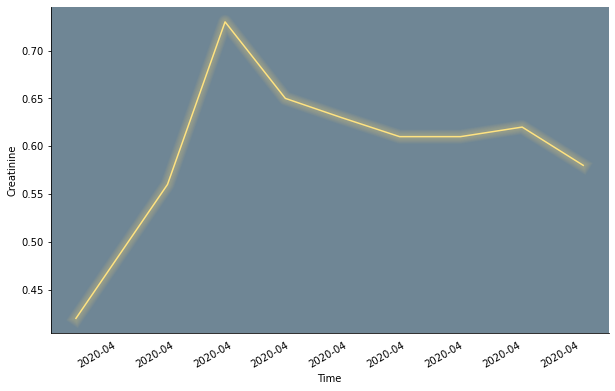

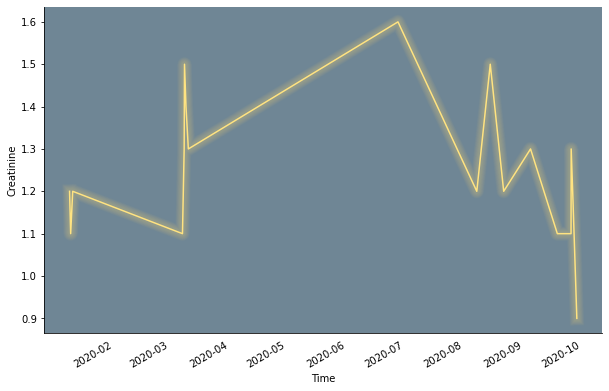

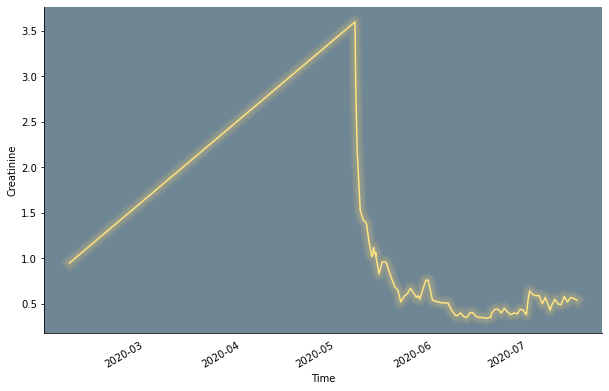

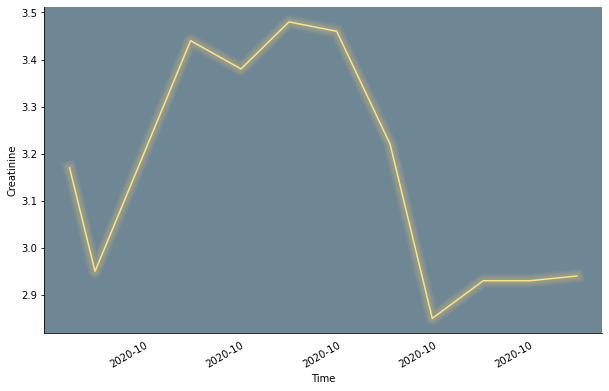

In [9]:
# RMW plot list is: ['MR2110315', 'MR282243', 'MR6496616', 'MR1226040', 'MR3869970']
plotCreatinineTrajectory('MR2110315', rows = slice(0,4)) # 00rmw
plotCreatinineTrajectory('MR282243') # 01rmw
plotCreatinineTrajectory('MR6496616') # 02rmw
plotCreatinineTrajectory('MR1226040') # 03rmw
plotCreatinineTrajectory('MR3869970') # 04rmw
plotCreatinineTrajectory('MR987642') # 05rmw

### HBT patients

In [ ]:
df

### BCI patients

In [ ]:
BCIpatients = ['MR1727893',
 'MR2053757',
 'MR2209263',
 'MR6052840',
 'MR4971056',
 'MR1062340',
 'MR503219',
 'MR1104237',
 'MR6161045',
 'MR1717307']

for p in BCIpatients:
    plotCreatinineTrajectory(p);

### RMW & HBT patients

In [ ]:
RMWandHBTpatients = list(captured_patients['RMW'].intersection(captured_patients['HBT']))[40:50]
for p in RMWandHBTpatients:
    plotCreatinineTrajectory(p, color = colors['ivory']);

### RMW & BCI patients

In [ ]:
RMWandBCIpatients = list(captured_patients['RMW'].intersection(captured_patients['BCI']))[60:70]
for p in RMWandBCIpatients:
    plotCreatinineTrajectory(p, color = colors['cinnabar']);

### HBT & BCI patients

In [ ]:
HBTandBCIpatients = list(captured_patients['HBT'].intersection(captured_patients['BCI']))[80:90]
for p in HBTandBCIpatients:
    plotCreatinineTrajectory(p);

### Patients captured by ALL 3 definitions

In [ ]:
ALL3patients = list(captured_patients['RMW'].intersection(captured_patients['HBT']).intersection(captured_patients['BCI']))[100:120]
for p in ALL3patients:
    plotCreatinineTrajectory(p, color = colors['cinnabar']);

In [ ]:
# TO CAPTURE FROM SETS --> 
plotSubset = flaggerOutput.loc[flaggerOutput.index.get_level_values(level='patient_id').isin(examplePatientsRMW)]

# TO HONE IN ON SINGLE PATIENTS --> 
#plotSubset = flaggerOutput.loc[flaggerOutput.index.get_level_values(level='patient_id') == 'MR282243']
plotSubset = plotSubset.merge(df.creatinine, on = index) # Add in the creatinine values from df
# plotSubset = plotSubset.reset_index()
# plotSubset['color'] = plotSubset.patient_id.map(colors) --> FIGURE OUT LATER: HOw to get independent coloring for each patient? (algorithmically rather than manually)
# plotSubset_ = plotSubset.pivot(index = 'time', columns = 'color', values = 'creatinine')
# plotSubset_.plot(color = plotSubset_.columns)

# Plotting
fig, ax = plt.subplots(nrows=1, ncols=1)
plt.plot(plotSubset.index.get_level_values(level='time'), plotSubset.creatinine)

examplePatient = None # Replace with sample patient 
e1_creatTS = df.loc[df.index.get_level_values(level='patient_id') == examplePatient, ['creatinine']]
plt.plot(e1_creatTS.time, e1_creatTS.creatinine)
plt.xlabel("time")
plt.ylabel("creatinine")
for t_aki in e1_creatTS[e1_creatTS.RMW].time:
    plt.arrow(x = t_aki, y = 0.3, dx=0, dy=0.5, width=0.08, color = '#FFEBC1')
    
# Parameters 
creatTS = df.loc[df.index.get_level_values(level='patient_id') == examplePatient, ['creatinine']] # this is the raw time series of the patient
draws = 10 # How many times to draw the line
diff_linewidth = 1.05 # Different line widths each draw
alpha_value = 0.03 # Alpha values of glow effect
glow_size = 5 # Glow linewidth
mainDrawColor = "#eae8ff"
bgColor = "#361F27"
# Nice colors (main trajectory): 
# green - "#00a676"
# pink - fe938c
# yellowgreen - E2F89C
# Laurel green - bdc4a7
# lavendar - eae8ff

# FIGURE 1: Create a figure for the creatinine trajectory
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(creatTS.index.get_level_values(level="time"), creatTS.creatinine, color = mainDrawColor) 
plt.xlabel("time")
plt.ylabel("creatinine")


arrowBounds = [sum(_) for _ in zip(list(e1_creatTS[e1_creatTS.RMW].creatinine)*3, [-0.3, 0, 0.3])]

axProps = dict()
axProps['text'] = "AKI event"
axProps['xy'] = (t_aki, arrowBounds[1])
axProps['xytext'] = (t_aki, arrowBounds[2])
axProps['arrowprops'] = {'arrowstyle': '-|>'}
axProps['va'] = 'center'
for t_aki in e1_creatTS[e1_creatTS.RMW].time:
    axProps = dict()
    axProps['text'] = "AKI event"
    axProps['xy'] = (t_aki, arrowBounds[1])
    axProps['xytext'] = (t_aki, arrowBounds[2])
    axProps['arrowprops'] = {'arrowstyle': '-|>'}
    axProps['va'] = 'center'
    ax.annotate(**axProps)
ax.set_facecolor(bgColor)
# Neon effect:
draws = 10 # How many times to draw the line
diff_linewidth = 1.05 # Different line widths each draw
alpha_value = 0.03 # Alpha values of glow effect
glow_size = 5 # Glow linewidth

for n in range(draws):
    ax.plot(creatTS.index.get_level_values(level="time"), creatTS.creatinine, color = mainDrawColor,
            linewidth=glow_size+(diff_linewidth*n), alpha = alpha_value)
# Nice bg colors:
# dark grey - #5d576b
# beige - #EFD09E
# burgundy - #361F27